In [1]:
install.packages(c('car','leaps','BMA', 'ggplot2', 'reshape'))

Installing packages into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)



In [2]:
library(car)
library(leaps)
library(BMA)
library(ggplot2)
library(reshape)

Loading required package: carData

Loading required package: survival

Loading required package: robustbase


Attaching package: ‘robustbase’


The following object is masked from ‘package:survival’:

    heart


Loading required package: inline

Loading required package: rrcov

Scalable Robust Estimators with High Breakdown Point (version 1.7-2)




## Data exploration

In [3]:
heart.data <- read.csv('heart_failure_data.csv', header = TRUE)

heart.data$DEATH_EVENT = as.factor(heart.data$DEATH_EVENT)

head(heart.data)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<fct>
1,75,0,582,0,20,1,265000,1.9,130,1,0,4,1
2,55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
3,65,0,146,0,20,0,162000,1.3,129,1,1,7,1
4,50,1,111,0,20,0,210000,1.9,137,1,0,7,1
5,65,1,160,1,20,0,327000,2.7,116,0,0,8,1
6,90,1,47,0,40,1,204000,2.1,132,1,1,8,1


Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”


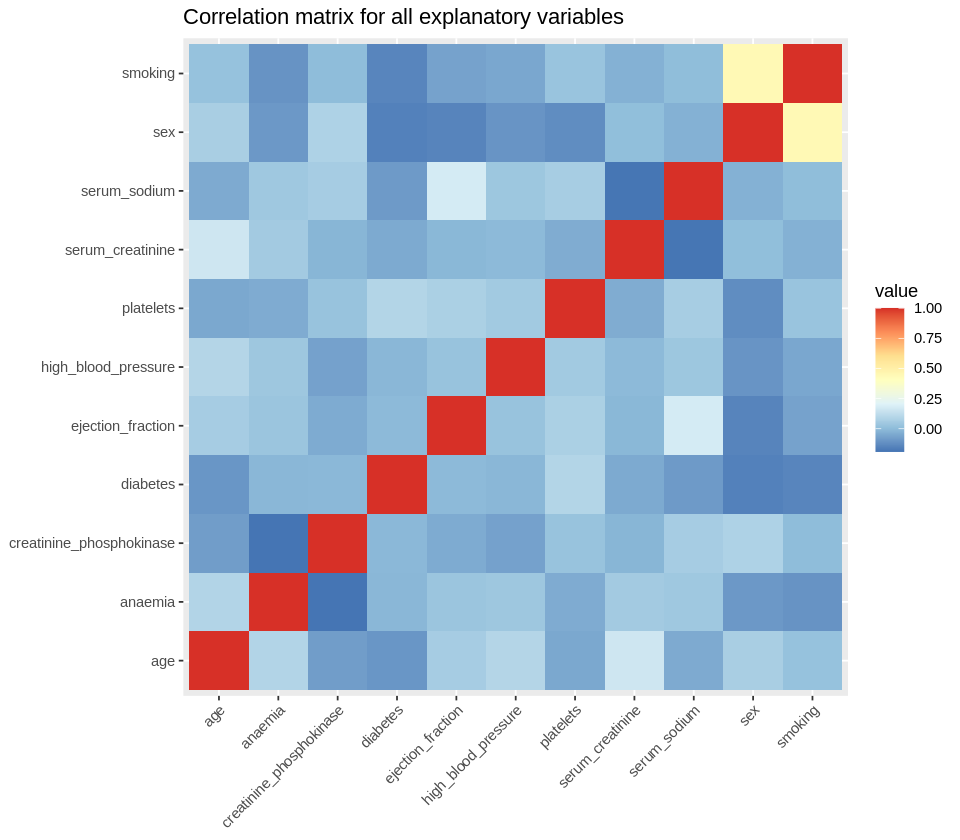

In [4]:
cor.mat <- cor(heart.data[,-c(12,13)])
melted.cor.mat <- melt(cor.mat, as.is = TRUE)

options(repr.plot.width = 8, repr.plot.height = 7)

ggplot(data = melted.cor.mat, aes(x = X1, y = X2, fill = value)) + 
    geom_tile() +
    theme(axis.text.x = element_text(angle = 45, hjust=1)) +
    scale_fill_distiller(palette = 'RdYlBu') +
    labs(title = 'Correlation matrix for all explanatory variables', x = NULL, y = NULL)

the highest correlatioin between variables is 0.44 between sex and smoking. This value is not very high so we shouldn't be worried about multicollinearity in our models.

## Model Selection

For testing purposes, first the data will be split into two different datasets: a training dataset and a testing dataset.

In [5]:
set.seed(9054)
sample <- sample(c(TRUE, FALSE), nrow(heart.data), replace=TRUE, prob=c(0.75,0.25))
train  <- heart.data[sample, ]
test   <- heart.data[!sample, ]

### Method 1: AIC

In [6]:
heart.model <- glm(DEATH_EVENT ~ . - time, data = train, family = 'binomial')
aic.model <- step(heart.model, trace = 0, direction = 'both')
summary(aic.model)


Call:
glm(formula = DEATH_EVENT ~ age + anaemia + creatinine_phosphokinase + 
    ejection_fraction + high_blood_pressure + serum_creatinine + 
    serum_sodium, family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2141  -0.7785  -0.4900   0.8797   2.4316  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)               6.7505465  5.2855823   1.277 0.201545    
age                       0.0522781  0.0140351   3.725 0.000195 ***
anaemia                   0.6048547  0.3335948   1.813 0.069810 .  
creatinine_phosphokinase  0.0003385  0.0001541   2.196 0.028091 *  
ejection_fraction        -0.0595662  0.0155965  -3.819 0.000134 ***
high_blood_pressure       0.5465407  0.3327625   1.642 0.100500    
serum_creatinine          0.6531168  0.2076362   3.145 0.001658 ** 
serum_sodium             -0.0737163  0.0390477  -1.888 0.059046 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 

Based on AIC, we should use a 7 variable model that uses age, anaemia, creatinine phosphokinase, ejection fraction, high blood pressure, serum creatinine and serum sodium.
However, we see that 4 of those variables have a p-values above 0.05, hence the coefficients variables are not statistically significant and we could remove them.

We can run a test to see if we should remove them based on accuracy of the model using our testing data. If the model outputs a value over 0.5, we can classify that as a prediction of a death event, and classify it as such.

In [7]:
aic.prob = predict(aic.model, test, type = 'response')

aic.pred = rep(0, dim(test)[1])
aic.pred[aic.prob > 0.5] = 1
mean(aic.pred == test$DEATH_EVENT)

[1] 0.8088235

### Method 2: BIC

In [8]:
bic.selection <- bic.glm(DEATH_EVENT ~ . - time, data = train, glm.family = 'binomial')
summary(bic.selection)


Call:
bic.glm.formula(f = DEATH_EVENT ~ . - time, data = train, glm.family = "binomial")


  13  models were selected
 Best  5  models (cumulative posterior probability =  0.7516 ): 

                          p!=0    EV         SD         model 1     model 2   
Intercept                 100    -1.187e+00  3.734e+00  -2.349e+00  -2.673e+00
age                       100.0   5.005e-02  1.342e-02   4.942e-02   5.190e-02
anaemia                     9.9   4.705e-02  1.752e-01       .           .    
creatinine_phosphokinase   21.6   5.554e-05  1.256e-04       .       2.432e-04
diabetes                    4.4   1.437e-02  9.494e-02       .           .    
ejection_fraction         100.0  -6.183e-02  1.536e-02  -6.219e-02  -6.201e-02
high_blood_pressure        13.3   6.692e-02  2.080e-01       .           .    
platelets                   2.9  -2.103e-08  3.041e-07       .           .    
serum_creatinine          100.0   6.453e-01  1.925e-01   6.442e-01   6.501e-01
serum_sodium             

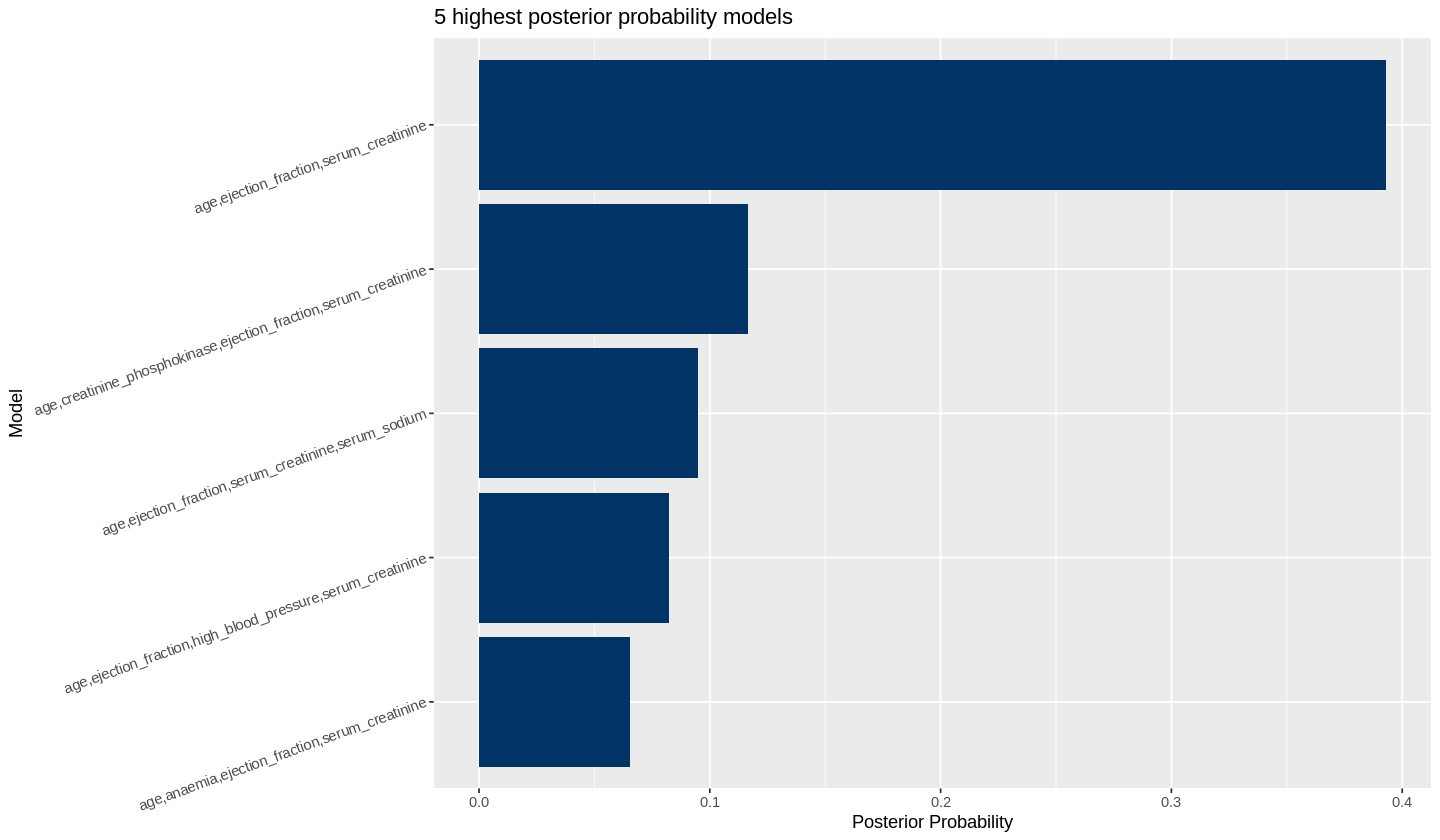

In [9]:
probs = data.frame(prob = bic.selection$postprob, labels = bic.selection$label)[1:5,]


options(repr.plot.width = 12, repr.plot.height = 7)
ggplot(data = probs, aes(y = reorder(labels, prob), x = prob)) + 
    geom_col(fill = '#003366') +
    labs(title = '5 highest posterior probability models', y = 'Model', x = 'Posterior Probability') +
    theme(axis.text.y = element_text(angle = 20, hjust=1))

Based on the BIC, and so on Bayesian posterior probabilities, the selected model is the model containaing age, ejection_fraction and serum_creatinine.

Once again, to verify this model, we can test the accuracy using the same data sets as we did with the AIC model.

In [10]:
bic.model = glm(DEATH_EVENT ~ age + ejection_fraction + serum_creatinine, 
                data = train, family = 'binomial')

summary(bic.model)


Call:
glm(formula = DEATH_EVENT ~ age + ejection_fraction + serum_creatinine, 
    family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2832  -0.8054  -0.5404   0.9708   2.3118  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -2.34879    0.91770  -2.559 0.010485 *  
age                0.04942    0.01324   3.733 0.000189 ***
ejection_fraction -0.06219    0.01523  -4.085 4.42e-05 ***
serum_creatinine   0.64418    0.18891   3.410 0.000649 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 294.07  on 230  degrees of freedom
Residual deviance: 247.10  on 227  degrees of freedom
AIC: 255.1

Number of Fisher Scoring iterations: 4


In [11]:
bic.prob = predict(bic.model, test, type = 'response')

bic.pred = rep(0, dim(test)[1])
bic.pred[bic.prob > 0.5] = 1
mean(bic.pred == test$DEATH_EVENT)

[1] 0.8382353

Although our second model has less variables included, it actually has a better prediction accuracy than that found using AIC. Hence we should take this one over the model found in Method 1. 